### Model

In [6]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [7]:
!git clone https://github.com/tzudir/Self_driving

fatal: destination path 'Self_driving' already exists and is not an empty directory.


In [8]:
datadir = '/content/Self_driving/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)

<ipython-input-8-04b2e98e549a>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [9]:
data.head(5)

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


In [10]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [11]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_01_25_22_48_25_466.jpg,left_2024_01_25_22_48_25_466.jpg,right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,center_2024_01_25_22_48_25_543.jpg,left_2024_01_25_22_48_25_543.jpg,right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,center_2024_01_25_22_48_25_622.jpg,left_2024_01_25_22_48_25_622.jpg,right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,center_2024_01_25_22_48_25_700.jpg,left_2024_01_25_22_48_25_700.jpg,right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,center_2024_01_25_22_48_25_769.jpg,left_2024_01_25_22_48_25_769.jpg,right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


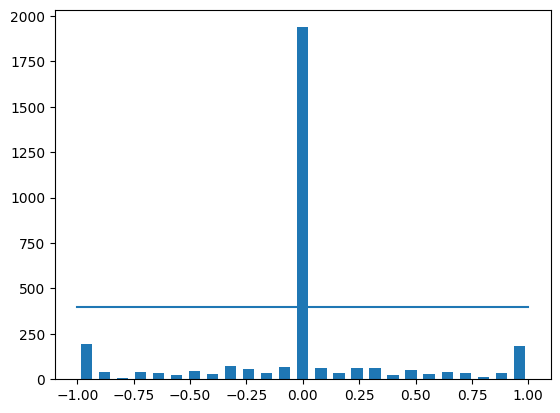

In [12]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [13]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  1538
remaining:  1667


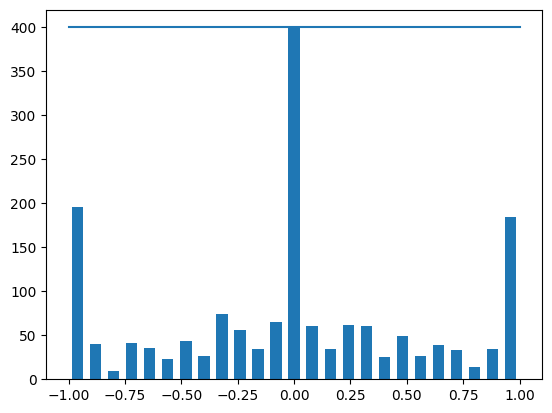

In [14]:
hist, bins = np.histogram(data['steering'], (num_bins))
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [15]:
data.shape

(1667, 7)

In [16]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [17]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [18]:
image_paths

array(['/content/Self_driving/data/IMG/center_2024_01_25_22_48_25_622.jpg',
       '/content/Self_driving/data/IMG/left_2024_01_25_22_48_25_622.jpg',
       '/content/Self_driving/data/IMG/right_2024_01_25_22_48_25_622.jpg',
       ...,
       '/content/Self_driving/data/IMG/center_2024_02_02_09_53_09_015.jpg',
       '/content/Self_driving/data/IMG/left_2024_02_02_09_53_09_015.jpg',
       '/content/Self_driving/data/IMG/right_2024_02_02_09_53_09_015.jpg'],
      dtype='<U65')

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 4000
Valid Samples: 1001


Text(0.5, 1.0, 'Validation set')

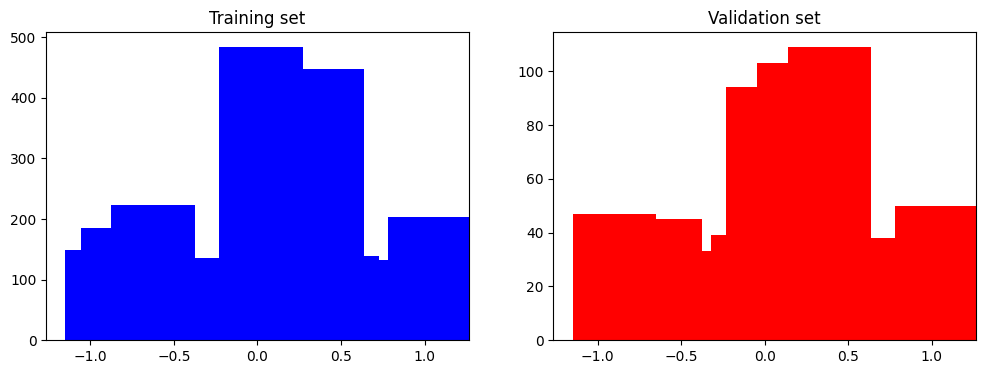

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width = 0.5, color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width = 0.5, color='red')
axes[1].set_title("Validation set")